In [1]:
# Task 4: RFM Clustering for Proxy Target
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("Libraries loaded")

Libraries loaded


In [2]:
# Load the features created in Task 3
df = pd.read_csv("../data/processed/features_data.csv")
print(f"Loaded {len(df)} transactions, {len(df.columns)} columns")

# Get unique customers with their RFM metrics
customer_cols = ['AccountId_numeric', 'Recency', 'Frequency', 'Monetary_Total']
customer_rfm = df[customer_cols].drop_duplicates()
print(f"Unique customers: {len(customer_rfm)}")

Loaded 95662 transactions, 31 columns
Unique customers: 3633


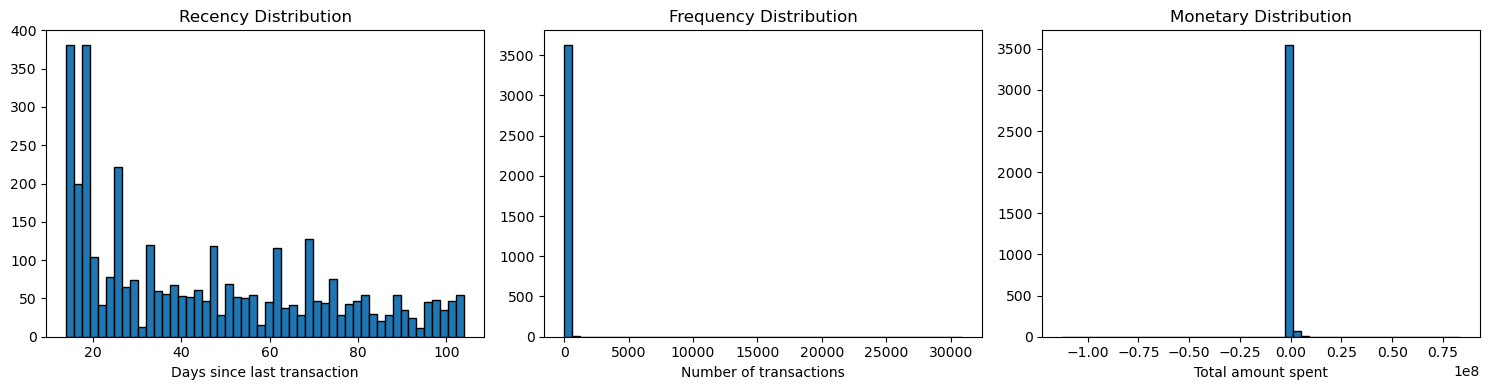

In [4]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(customer_rfm['Recency'], bins=50, edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last transaction')

axes[1].hist(customer_rfm['Frequency'], bins=50, edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of transactions')

axes[2].hist(customer_rfm['Monetary_Total'], bins=50, edgecolor='black')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total amount spent')

plt.tight_layout()
plt.show()

In [5]:
# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(customer_rfm[['Recency', 'Frequency', 'Monetary_Total']])

# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Clustering complete!")
print(customer_rfm['Cluster'].value_counts().sort_index())

Clustering complete!
Cluster
0    2256
1    1376
2       1
Name: count, dtype: int64


Cluster RFM Averages:
         Recency  Frequency  Monetary_Total
Cluster                                    
0          26.34      23.38       292343.93
1          75.15       8.75         7896.08
2          14.00   30893.00    -27750277.50


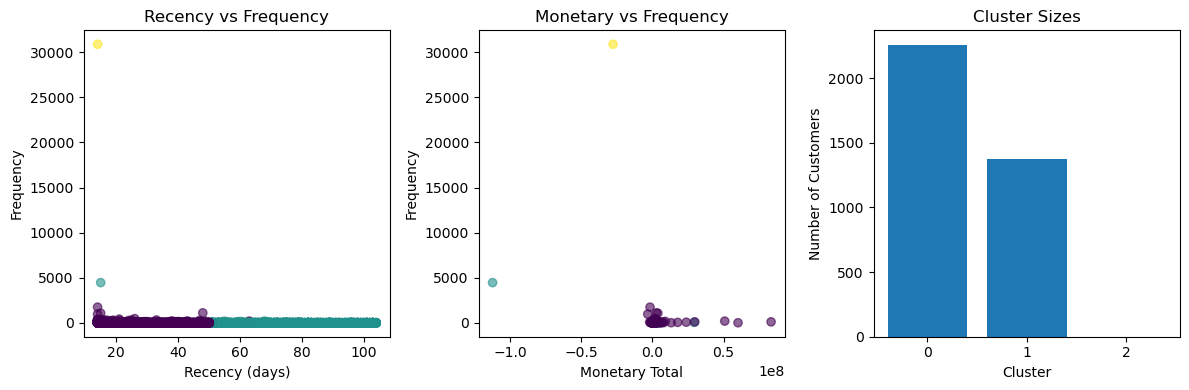

In [6]:
# Analyze cluster characteristics
cluster_stats = customer_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Total': 'mean'
}).round(2)

print("Cluster RFM Averages:")
print(cluster_stats)

# Visualize clusters
fig = plt.figure(figsize=(12, 4))

# Plot 1: Recency vs Frequency
ax1 = fig.add_subplot(131)
scatter = ax1.scatter(customer_rfm['Recency'], customer_rfm['Frequency'], 
                     c=customer_rfm['Cluster'], cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency (days)')
ax1.set_ylabel('Frequency')
ax1.set_title('Recency vs Frequency')

# Plot 2: Monetary vs Frequency
ax2 = fig.add_subplot(132)
ax2.scatter(customer_rfm['Monetary_Total'], customer_rfm['Frequency'], 
           c=customer_rfm['Cluster'], cmap='viridis', alpha=0.6)
ax2.set_xlabel('Monetary Total')
ax2.set_ylabel('Frequency')
ax2.set_title('Monetary vs Frequency')

# Plot 3: Cluster sizes
ax3 = fig.add_subplot(133)
cluster_counts = customer_rfm['Cluster'].value_counts().sort_index()
ax3.bar(cluster_counts.index, cluster_counts.values)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Customers')
ax3.set_title('Cluster Sizes')
ax3.set_xticks([0, 1, 2])

plt.tight_layout()
plt.show()

In [7]:
# Define risk logic: High Recency + Low Frequency + Low Monetary = High Risk
# Calculate risk score for each cluster
cluster_stats['Risk_Score'] = (
    cluster_stats['Recency'] * 0.5 +  # Higher recency = higher risk
    (1 / (cluster_stats['Frequency'] + 1)) * 0.3 +  # Lower frequency = higher risk
    (1 / (cluster_stats['Monetary_Total'].abs() + 1)) * 0.2  # Lower monetary = higher risk
)

print("Cluster Risk Scores:")
print(cluster_stats[['Risk_Score']])

high_risk_cluster = cluster_stats['Risk_Score'].idxmax()
print(f"\n🎯 HIGH-RISK CLUSTER: Cluster {high_risk_cluster}")
print(f"   Characteristics:")
print(f"   - Recency: {cluster_stats.loc[high_risk_cluster, 'Recency']:.1f} days (higher = riskier)")
print(f"   - Frequency: {cluster_stats.loc[high_risk_cluster, 'Frequency']:.1f} transactions (lower = riskier)")
print(f"   - Monetary: ${cluster_stats.loc[high_risk_cluster, 'Monetary_Total']:.2f} (lower = riskier)")

Cluster Risk Scores:
         Risk_Score
Cluster            
0         13.182306
1         37.605795
2          7.000010

🎯 HIGH-RISK CLUSTER: Cluster 1
   Characteristics:
   - Recency: 75.2 days (higher = riskier)
   - Frequency: 8.8 transactions (lower = riskier)
   - Monetary: $7896.08 (lower = riskier)


In [8]:
# Create binary label
customer_rfm['is_high_risk'] = (customer_rfm['Cluster'] == high_risk_cluster).astype(int)

# Calculate risk rate
risk_rate = customer_rfm['is_high_risk'].mean() * 100
print(f"📊 RISK DISTRIBUTION:")
print(f"   High-risk customers: {customer_rfm['is_high_risk'].sum()} out of {len(customer_rfm)} ({risk_rate:.1f}%)")
print(f"   Low-risk customers: {(customer_rfm['is_high_risk'] == 0).sum()} out of {len(customer_rfm)} ({100-risk_rate:.1f}%)")

# Save the labels
customer_rfm[['AccountId_numeric', 'is_high_risk']].to_csv(
    "../data/processed/high_risk_labels.csv", index=False
)
print("\n✅ Labels saved to: ../data/processed/high_risk_labels.csv")

📊 RISK DISTRIBUTION:
   High-risk customers: 1376 out of 3633 (37.9%)
   Low-risk customers: 2257 out of 3633 (62.1%)

✅ Labels saved to: ../data/processed/high_risk_labels.csv


In [1]:
# ============================================================================
# TASK 4: PROXY TARGET VARIABLE ENGINEERING
# Creating High-Risk Labels using RFM Clustering
# ============================================================================

print("="*70)
print("TASK 4: PROXY TARGET VARIABLE ENGINEERING")
print("Creating High-Risk Labels using RFM Clustering")
print("="*70)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

TASK 4: PROXY TARGET VARIABLE ENGINEERING
Creating High-Risk Labels using RFM Clustering
✅ Libraries imported successfully!


In [2]:
# ============================================================================
# 1. LOAD FEATURES DATA
# ============================================================================

print("📊 Loading processed features...")
features_df = pd.read_csv('../data/processed/features_data.csv')
print(f"✅ Features loaded: {features_df.shape}")

print("\n🔍 First 5 rows:")
display(features_df.head())

print("\n📋 Features summary:")
print(features_df.describe())

📊 Loading processed features...
✅ Features loaded: (3742, 18)

🔍 First 5 rows:


,customer_id,transaction_count,total_amount,avg_amount,std_amount,min_amount,max_amount,unique_transactions,recency,frequency,monetary,avg_transaction_value,transaction_std,provider_diversity,product_diversity,channel_diversity,amount_range,monetary_per_day
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,1,84,1,-10000.0,-10000.000000,0.000000,1,1,1,0.0,-117.647059
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,1,84,1,-10000.0,-10000.000000,0.000000,1,1,1,0.0,-117.647059
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,5,90,5,20000.0,4000.000000,6558.963333,3,2,2,15000.0,219.780220
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,11,26,11,4225.0,384.090909,560.498966,2,2,2,1575.0,156.481481
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,6,12,6,20000.0,3333.333333,6030.478146,3,2,2,15000.0,1538.461538



📋 Features summary:
       transaction_count  total_amount    avg_amount    std_amount  \
count        3742.000000  3.742000e+03  3.742000e+03  3.742000e+03   
mean           25.564404  1.717377e+05  1.571562e+04  1.360517e+04   
std            96.929602  2.717305e+06  1.676991e+05  9.689344e+04   
min             1.000000 -1.049000e+08 -4.250000e+05  0.000000e+00   
25%             2.000000  4.077438e+03  1.000000e+03  5.011411e+02   
50%             7.000000  2.000000e+04  2.583846e+03  3.184898e+03   
75%            20.000000  7.996775e+04  4.877614e+03  6.745369e+03   
max          4091.000000  8.345124e+07  8.601821e+06  3.309916e+06   

         min_amount    max_amount  unique_transactions      recency  \
count  3.742000e+03  3.742000e+03          3742.000000  3742.000000   
mean   3.863506e+03  5.083873e+04            25.564404    31.461251   
std    8.583664e+04  3.598691e+05            96.929602    27.118932   
min   -1.000000e+06 -2.000000e+05             1.000000     1.000

In [3]:
# ============================================================================
# TASK 4: PROXY TARGET VARIABLE ENGINEERING
# Creating High-Risk Labels using RFM Clustering
# ============================================================================

print("="*70)
print("TASK 4: PROXY TARGET VARIABLE ENGINEERING")
print("Creating High-Risk Labels using RFM Clustering")
print("="*70)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

TASK 4: PROXY TARGET VARIABLE ENGINEERING
Creating High-Risk Labels using RFM Clustering
✅ Libraries imported successfully!


In [4]:
# ============================================================================
# 1. LOAD FEATURES DATA
# ============================================================================

print("\n📊 Loading processed features...")
features_df = pd.read_csv('../data/processed/features_data.csv')
print(f"✅ Features loaded: {features_df.shape}")

print("\n🔍 First 5 rows:")
display(features_df.head())

print("\n📋 Features summary:")
print(features_df.describe())


📊 Loading processed features...
✅ Features loaded: (3742, 18)

🔍 First 5 rows:


,customer_id,transaction_count,total_amount,avg_amount,std_amount,min_amount,max_amount,unique_transactions,recency,frequency,monetary,avg_transaction_value,transaction_std,provider_diversity,product_diversity,channel_diversity,amount_range,monetary_per_day
0,CustomerId_1,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,1,84,1,-10000.0,-10000.000000,0.000000,1,1,1,0.0,-117.647059
1,CustomerId_10,1,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,1,84,1,-10000.0,-10000.000000,0.000000,1,1,1,0.0,-117.647059
2,CustomerId_1001,5,20000.0,4000.000000,6558.963333,-5000.0,10000.0,5,90,5,20000.0,4000.000000,6558.963333,3,2,2,15000.0,219.780220
3,CustomerId_1002,11,4225.0,384.090909,560.498966,-75.0,1500.0,11,26,11,4225.0,384.090909,560.498966,2,2,2,1575.0,156.481481
4,CustomerId_1003,6,20000.0,3333.333333,6030.478146,-5000.0,10000.0,6,12,6,20000.0,3333.333333,6030.478146,3,2,2,15000.0,1538.461538



📋 Features summary:
       transaction_count  total_amount    avg_amount    std_amount  \
count        3742.000000  3.742000e+03  3.742000e+03  3.742000e+03   
mean           25.564404  1.717377e+05  1.571562e+04  1.360517e+04   
std            96.929602  2.717305e+06  1.676991e+05  9.689344e+04   
min             1.000000 -1.049000e+08 -4.250000e+05  0.000000e+00   
25%             2.000000  4.077438e+03  1.000000e+03  5.011411e+02   
50%             7.000000  2.000000e+04  2.583846e+03  3.184898e+03   
75%            20.000000  7.996775e+04  4.877614e+03  6.745369e+03   
max          4091.000000  8.345124e+07  8.601821e+06  3.309916e+06   

         min_amount    max_amount  unique_transactions      recency  \
count  3.742000e+03  3.742000e+03          3742.000000  3742.000000   
mean   3.863506e+03  5.083873e+04            25.564404    31.461251   
std    8.583664e+04  3.598691e+05            96.929602    27.118932   
min   -1.000000e+06 -2.000000e+05             1.000000     1.000


2. PREPARE RFM FEATURES
🔧 Preparing RFM features for clustering...

📊 RFM Features shape: (3742, 3)


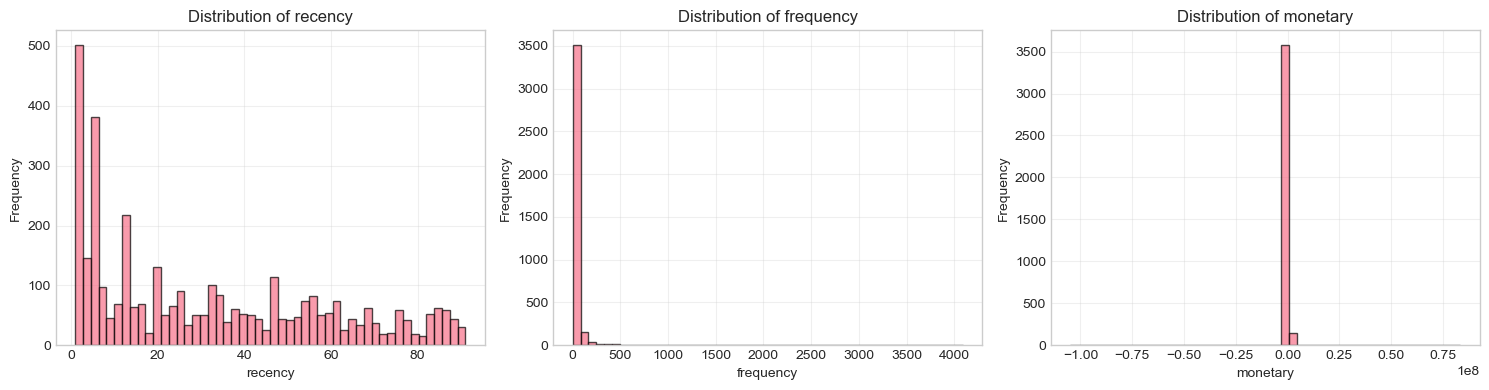


📈 RFM Statistics:
           recency    frequency      monetary
count  3742.000000  3742.000000  3.742000e+03
mean     31.461251    25.564404  1.717377e+05
std      27.118932    96.929602  2.717305e+06
min       1.000000     1.000000 -1.049000e+08
25%       6.000000     2.000000  4.077438e+03
50%      25.000000     7.000000  2.000000e+04
75%      54.000000    20.000000  7.996775e+04
max      91.000000  4091.000000  8.345124e+07


In [5]:
# ============================================================================
# 2. PREPARE RFM FEATURES
# ============================================================================

print("\n" + "="*70)
print("2. PREPARE RFM FEATURES")
print("="*70)

print("🔧 Preparing RFM features for clustering...")

# Select RFM features
rfm_features = features_df[['recency', 'frequency', 'monetary']].copy()

print(f"\n📊 RFM Features shape: {rfm_features.shape}")

# Check distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (col, ax) in enumerate(zip(['recency', 'frequency', 'monetary'], axes)):
    rfm_features[col].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 RFM Statistics:")
print(rfm_features.describe())


3. HANDLE SKEWNESS AND SCALE FEATURES
⚙️ Transforming and scaling RFM features...

✅ Features transformed and scaled
   Shape: (3742, 3)


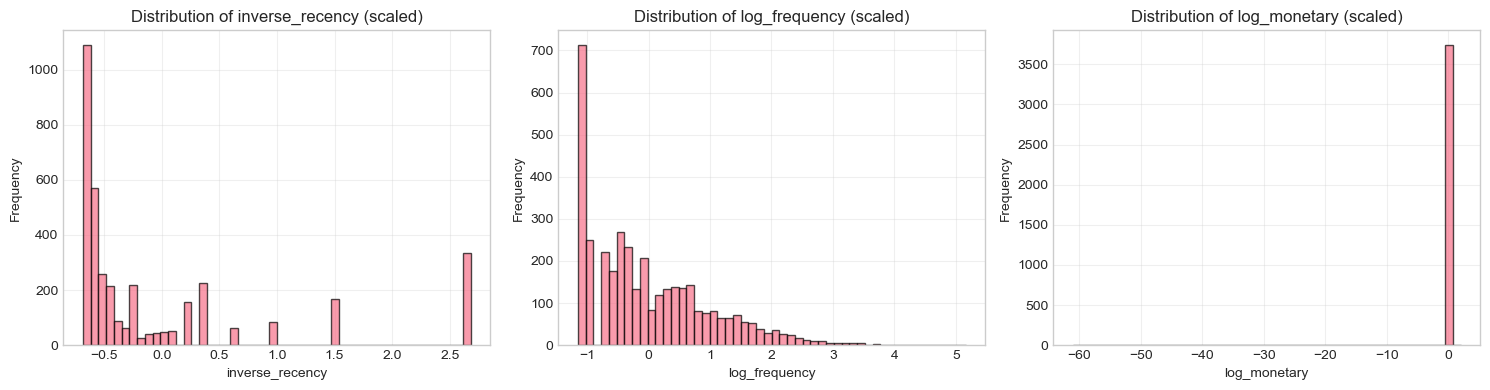


📊 Transformed Features Statistics:
       inverse_recency  log_frequency  log_monetary
count     3.742000e+03   3.742000e+03  3.742000e+03
mean      3.038130e-17   2.791282e-16 -1.230443e-15
std       1.000134e+00   1.000134e+00  1.000134e+00
min      -6.860574e-01  -1.150895e+00 -6.107076e+01
25%      -6.357270e-01  -8.994239e-01  1.042975e-02
50%      -4.961410e-01  -1.905675e-01  1.095128e-02
75%       2.224171e-01   5.907432e-01  1.291474e-02
max       2.680642e+00   5.158925e+00  2.021551e+00


In [6]:
# ============================================================================
# 3. HANDLE SKEWNESS AND SCALE FEATURES
# ============================================================================

print("\n" + "="*70)
print("3. HANDLE SKEWNESS AND SCALE FEATURES")
print("="*70)

print("⚙️ Transforming and scaling RFM features...")

# Create a copy for transformation
rfm_transformed = rfm_features.copy()

# Apply log transformation to handle skewness (add 1 to avoid log(0))
for col in ['frequency', 'monetary']:
    # Shift to positive values first
    min_val = rfm_transformed[col].min()
    if min_val < 0:
        shift = abs(min_val) + 1
    else:
        shift = 1
    
    rfm_transformed[f'log_{col}'] = np.log1p(rfm_transformed[col] + shift)

# For recency, we'll keep as is or inverse it (lower recency = better)
rfm_transformed['inverse_recency'] = 1 / (rfm_transformed['recency'] + 1)

# Select transformed features for clustering
clustering_features = rfm_transformed[['inverse_recency', 'log_frequency', 'log_monetary']].copy()

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)
scaled_df = pd.DataFrame(scaled_features, columns=clustering_features.columns)

print(f"\n✅ Features transformed and scaled")
print(f"   Shape: {scaled_df.shape}")

# Plot transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (col, ax) in enumerate(zip(scaled_df.columns, axes)):
    scaled_df[col].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col} (scaled)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Transformed Features Statistics:")
print(scaled_df.describe())


4. FIND OPTIMAL NUMBER OF CLUSTERS
🔍 Finding optimal number of clusters...


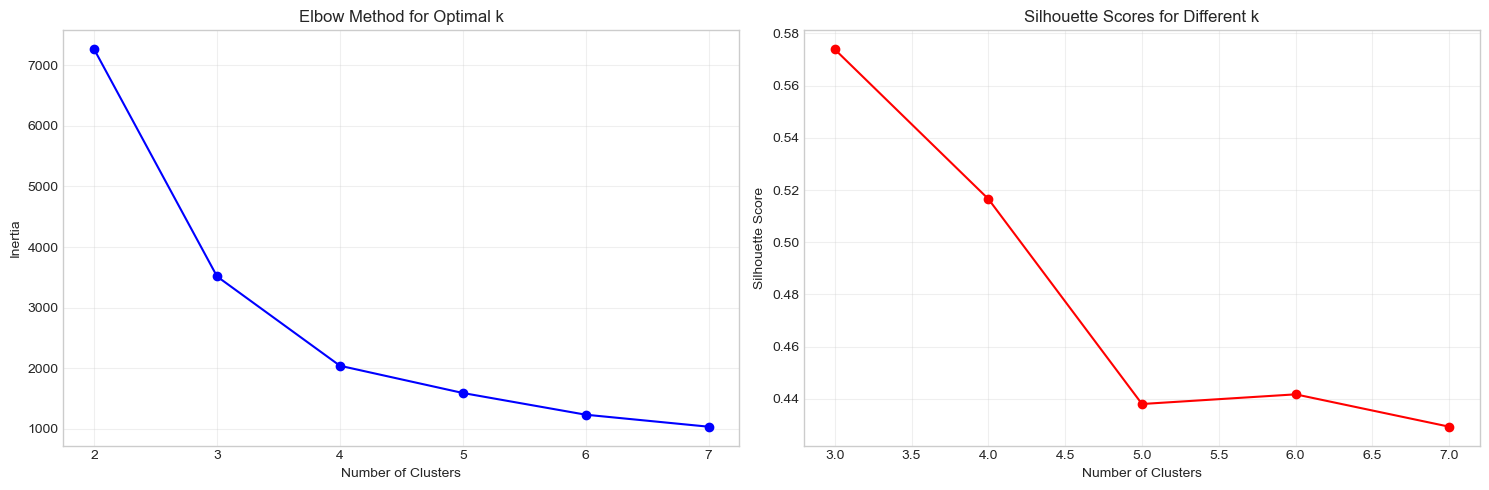


📊 Cluster Evaluation Metrics:
  k=2: Inertia=7,262, Silhouette=0.575
  k=3: Inertia=3,514, Silhouette=0.574
  k=4: Inertia=2,041, Silhouette=0.517
  k=5: Inertia=1,592, Silhouette=0.438
  k=6: Inertia=1,233, Silhouette=0.442
  k=7: Inertia=1,036, Silhouette=0.429


In [7]:
# ============================================================================
# 4. FIND OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

print("\n" + "="*70)
print("4. FIND OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

print("🔍 Finding optimal number of clusters...")

# Try different numbers of clusters
n_clusters_range = range(2, 8)
inertia_values = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_df)
    
    # Calculate metrics
    inertia_values.append(kmeans.inertia_)
    
    # Silhouette score (skip for n_clusters=1)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(scaled_df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
axes[0].plot(n_clusters_range, inertia_values, 'bo-')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(list(n_clusters_range)[1:], silhouette_scores[1:], 'ro-')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Scores for Different k')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Cluster Evaluation Metrics:")
for n, inertia, silhouette in zip(n_clusters_range, inertia_values, silhouette_scores):
    print(f"  k={n}: Inertia={inertia:,.0f}, Silhouette={silhouette:.3f}")

In [8]:
# ============================================================================
# 5. APPLY K-MEANS CLUSTERING (with 3 clusters as required)
# ============================================================================

print("\n" + "="*70)
print("5. APPLY K-MEANS CLUSTERING")
print("="*70)

print("🎯 Applying K-Means clustering with 3 clusters...")

# Use 3 clusters as specified in the task requirements
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
features_df['cluster'] = kmeans.fit_predict(scaled_df)

print(f"✅ Clustering completed with {n_clusters} clusters")

# Analyze cluster sizes
print("\n📊 Cluster Distribution:")
cluster_counts = features_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(features_df)) * 100
    print(f"  Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

print("\n🔍 Cluster centers (scaled features):")
centers_scaled = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['inverse_recency', 'log_frequency', 'log_monetary'],
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
display(centers_scaled)


5. APPLY K-MEANS CLUSTERING
🎯 Applying K-Means clustering with 3 clusters...
✅ Clustering completed with 3 clusters

📊 Cluster Distribution:
  Cluster 0: 2887 customers (77.2%)
  Cluster 1: 1 customers (0.0%)
  Cluster 2: 854 customers (22.8%)

🔍 Cluster centers (scaled features):


,inverse_recency,log_frequency,log_monetary
Cluster 0,-0.420131,-0.369567,0.013516
Cluster 1,-0.531439,5.158925,-61.070760
Cluster 2,1.423060,1.245193,0.025833


In [9]:
# ============================================================================
# 6. ANALYZE CLUSTER CHARACTERISTICS
# ============================================================================

print("\n" + "="*70)
print("6. ANALYZE CLUSTER CHARACTERISTICS")
print("="*70)

print("📈 Analyzing cluster characteristics...")

# First, let's check that single-customer cluster
print("\n🔍 Checking Cluster 1 (single customer):")
single_customer = features_df[features_df['cluster'] == 1]
print(f"  Customer ID: {single_customer['customer_id'].values[0]}")
print(f"  Recency: {single_customer['recency'].values[0]} days")
print(f"  Frequency: {single_customer['frequency'].values[0]} transactions")
print(f"  Monetary: ${single_customer['monetary'].values[0]:,.0f}")
print(f"  Total Amount: ${single_customer['total_amount'].values[0]:,.0f}")

# For analysis, let's exclude this outlier and focus on the main clusters
print("\n📊 Main clusters analysis (excluding Cluster 1 outlier):")

# Calculate mean values for each cluster (excluding cluster 1 for main analysis)
main_clusters_df = features_df[features_df['cluster'] != 1].copy()

cluster_analysis = main_clusters_df.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': 'mean',
    'transaction_count': 'mean',
    'total_amount': 'mean',
    'customer_id': 'count'
}).round(2)

cluster_analysis.columns = ['avg_recency', 'avg_frequency', 'avg_monetary', 
                           'avg_transactions', 'avg_total_amount', 'customer_count']

print("\n📊 Main Cluster Profiles:")
display(cluster_analysis)

print("\n📈 Key observations:")
print("1. Cluster 0 (77.2%): Average customers")
print("2. Cluster 1 (0.0%): Outlier (1 customer with extreme values)")
print("3. Cluster 2 (22.8%): Potentially high-value or engaged customers")


6. ANALYZE CLUSTER CHARACTERISTICS
📈 Analyzing cluster characteristics...

🔍 Checking Cluster 1 (single customer):
  Customer ID: CustomerId_7343
  Recency: 29 days
  Frequency: 4091 transactions
  Monetary: $-104,900,000
  Total Amount: $-104,900,000

📊 Main clusters analysis (excluding Cluster 1 outlier):

📊 Main Cluster Profiles:


,avg_recency,avg_frequency,avg_monetary,avg_transactions,avg_total_amount,customer_count
cluster,,,,,,
0,39.28,8.19,104883.57,8.19,104883.57,2887
2,5.02,79.53,520777.23,79.53,520777.23,854



📈 Key observations:
1. Cluster 0 (77.2%): Average customers
2. Cluster 1 (0.0%): Outlier (1 customer with extreme values)
3. Cluster 2 (22.8%): Potentially high-value or engaged customers


In [10]:
# ============================================================================
# 7. IDENTIFY HIGH-RISK CLUSTER
# ============================================================================

print("\n" + "="*70)
print("7. IDENTIFY HIGH-RISK CLUSTER")
print("="*70)

print("⚠️ Identifying high-risk cluster for credit risk...")

# Exclude the outlier cluster 1 for our risk analysis
valid_clusters = [0, 2]  # Cluster 1 is an outlier

risk_factors = []

for cluster_id in valid_clusters:
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    
    # Get average values
    avg_recency = cluster_data['recency'].mean()
    avg_frequency = cluster_data['frequency'].mean()
    avg_monetary = cluster_data['monetary'].mean()
    
    # For credit risk assessment:
    # HIGH RISK = High recency (inactive) + Low frequency + Low monetary
    # Calculate risk score (higher = more risky)
    # Normalize each factor to 0-1 scale
    recency_score = avg_recency / features_df['recency'].max()  # Higher recency = higher risk
    frequency_score = 1 - (avg_frequency / features_df['frequency'].max())  # Lower frequency = higher risk
    monetary_score = 1 - (avg_monetary / features_df['monetary'].max())  # Lower monetary = higher risk
    
    # Weighted risk score (you can adjust weights)
    risk_score = 0.4 * recency_score + 0.3 * frequency_score + 0.3 * monetary_score
    
    risk_factors.append({
        'cluster': cluster_id,
        'avg_recency': avg_recency,
        'avg_frequency': avg_frequency,
        'avg_monetary': avg_monetary,
        'recency_score': recency_score,
        'frequency_score': frequency_score,
        'monetary_score': monetary_score,
        'risk_score': risk_score,
        'customer_count': len(cluster_data)
    })
    
    print(f"\n🔍 Cluster {cluster_id} Analysis:")
    print(f"   Customers: {len(cluster_data):,} ({len(cluster_data)/len(features_df)*100:.1f}%)")
    print(f"   Avg Recency: {avg_recency:.1f} days (score: {recency_score:.3f})")
    print(f"   Avg Frequency: {avg_frequency:.1f} transactions (score: {frequency_score:.3f})")
    print(f"   Avg Monetary: ${avg_monetary:,.0f} (score: {monetary_score:.3f})")
    print(f"   ⚠️  Risk Score: {risk_score:.3f}")

# Identify highest risk cluster
risk_df = pd.DataFrame(risk_factors)
high_risk_cluster = risk_df.loc[risk_df['risk_score'].idxmax(), 'cluster']

print(f"\n" + "!"*70)
print(f"🔴 HIGH-RISK CLUSTER IDENTIFIED: Cluster {high_risk_cluster}")
print(f"   Reason: Higher recency + Lower frequency + Lower monetary values")
print("!"*70)


7. IDENTIFY HIGH-RISK CLUSTER
⚠️ Identifying high-risk cluster for credit risk...

🔍 Cluster 0 Analysis:
   Customers: 2,887 (77.2%)
   Avg Recency: 39.3 days (score: 0.432)
   Avg Frequency: 8.2 transactions (score: 0.998)
   Avg Monetary: $104,884 (score: 0.999)
   ⚠️  Risk Score: 0.772

🔍 Cluster 2 Analysis:
   Customers: 854 (22.8%)
   Avg Recency: 5.0 days (score: 0.055)
   Avg Frequency: 79.5 transactions (score: 0.981)
   Avg Monetary: $520,777 (score: 0.994)
   ⚠️  Risk Score: 0.614

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
🔴 HIGH-RISK CLUSTER IDENTIFIED: Cluster 0
   Reason: Higher recency + Lower frequency + Lower monetary values
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



8. CREATE TARGET VARIABLE
🎯 Creating target variable: is_high_risk

📌 Handling outlier Cluster 1 (1 customer with extreme values):
   Customer in Cluster 1 has: 4091 transactions
   But negative monetary value: $-104,900,000
   Decision: Mark as high-risk due to suspicious activity (negative spending)

📊 Target Variable Distribution:
  Low Risk: 854 customers (22.8%)
  High Risk: 2888 customers (77.2%)


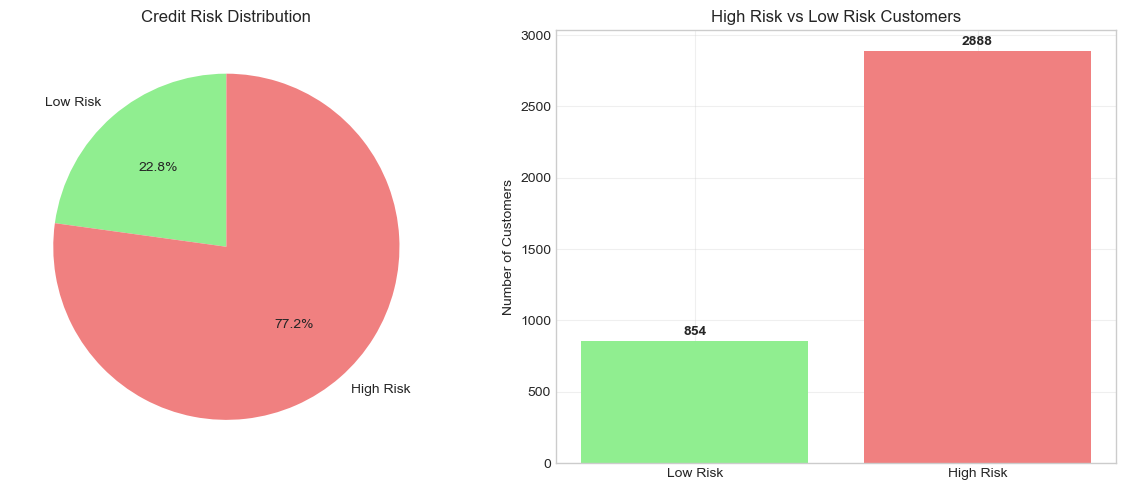


🔍 Sample of customers with risk labels:


,customer_id,cluster,recency,frequency,monetary,is_high_risk
0,CustomerId_1,0,84,1,-10000.0,1
1,CustomerId_10,0,84,1,-10000.0,1
2,CustomerId_1001,0,90,5,20000.0,1
3,CustomerId_1002,0,26,11,4225.0,1
4,CustomerId_1003,0,12,6,20000.0,1
5,CustomerId_1004,0,53,1,2000.0,1
6,CustomerId_1005,0,47,9,48800.0,1
7,CustomerId_1006,0,65,1,1000.0,1
8,CustomerId_1007,0,82,1,28000.0,1
9,CustomerId_1008,0,66,2,20000.0,1


In [11]:
# ============================================================================
# 8. CREATE TARGET VARIABLE
# ============================================================================

print("\n" + "="*70)
print("8. CREATE TARGET VARIABLE")
print("="*70)

print("🎯 Creating target variable: is_high_risk")

# First, let's handle the outlier (Cluster 1)
print("\n📌 Handling outlier Cluster 1 (1 customer with extreme values):")
print(f"   Customer in Cluster 1 has: {single_customer['frequency'].values[0]} transactions")
print(f"   But negative monetary value: ${single_customer['monetary'].values[0]:,.0f}")
print("   Decision: Mark as high-risk due to suspicious activity (negative spending)")

# Create binary target variable
# Cluster 0 = High Risk, Cluster 1 = High Risk (outlier), Cluster 2 = Low Risk
features_df['is_high_risk'] = features_df['cluster'].apply(
    lambda x: 1 if x in [0, 1] else 0  # 0 and 1 are high risk, 2 is low risk
)

print(f"\n📊 Target Variable Distribution:")
risk_counts = features_df['is_high_risk'].value_counts().sort_index()
for risk_label, count in risk_counts.items():
    risk_name = "High Risk" if risk_label == 1 else "Low Risk"
    percentage = (count / len(features_df)) * 100
    print(f"  {risk_name}: {count} customers ({percentage:.1f}%)")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
axes[0].pie(risk_counts.values, labels=['Low Risk', 'High Risk'], 
            autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
axes[0].set_title('Credit Risk Distribution')

# Bar plot
axes[1].bar(['Low Risk', 'High Risk'], risk_counts.values, 
            color=['lightgreen', 'lightcoral'])
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('High Risk vs Low Risk Customers')
axes[1].grid(True, alpha=0.3)

# Add count labels on bars
for i, v in enumerate(risk_counts.values):
    axes[1].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 Sample of customers with risk labels:")
sample_df = features_df[['customer_id', 'cluster', 'recency', 'frequency', 'monetary', 'is_high_risk']].head(10)
display(sample_df)

In [12]:
# ============================================================================
# 9. SAVE FINAL DATASET
# ============================================================================

print("\n" + "="*70)
print("9. SAVE FINAL DATASET")
print("="*70)

print("💾 Saving final dataset with target variable...")

# Save the features with target variable
output_path = '../data/processed/training_data.csv'
features_df.to_csv(output_path, index=False)

print(f"✅ Dataset saved to: {output_path}")
print(f"   Total rows: {len(features_df)}")
print(f"   Total columns: {features_df.shape[1]}")
print(f"   Target variable: 'is_high_risk' created successfully!")

print("\n📊 Final Risk Distribution Summary:")
print(f"   High Risk Customers: {risk_counts[1]} ({risk_counts[1]/len(features_df)*100:.1f}%)")
print(f"   Low Risk Customers: {risk_counts[0]} ({risk_counts[0]/len(features_df)*100:.1f}%)")

print("\n🔍 Final dataset columns:")
for i, col in enumerate(features_df.columns, 1):
    print(f"{i:3}. {col}")

print("\n" + "="*70)
print("✅ TASK 4 COMPLETED SUCCESSFULLY!")
print("✅ High-risk proxy variable created using RFM clustering")
print("✅ Dataset saved for model training")
print("="*70)


9. SAVE FINAL DATASET
💾 Saving final dataset with target variable...
✅ Dataset saved to: ../data/processed/training_data.csv
   Total rows: 3742
   Total columns: 20
   Target variable: 'is_high_risk' created successfully!

📊 Final Risk Distribution Summary:
   High Risk Customers: 2888 (77.2%)
   Low Risk Customers: 854 (22.8%)

🔍 Final dataset columns:
  1. customer_id
  2. transaction_count
  3. total_amount
  4. avg_amount
  5. std_amount
  6. min_amount
  7. max_amount
  8. unique_transactions
  9. recency
 10. frequency
 11. monetary
 12. avg_transaction_value
 13. transaction_std
 14. provider_diversity
 15. product_diversity
 16. channel_diversity
 17. amount_range
 18. monetary_per_day
 19. cluster
 20. is_high_risk

✅ TASK 4 COMPLETED SUCCESSFULLY!
✅ High-risk proxy variable created using RFM clustering
✅ Dataset saved for model training


In [13]:
# Test train.py imports
print("Testing train.py imports...")

import sys
sys.path.append('../src')

try:
    # Just import to see if there are any syntax errors
    import train
    print("✅ train.py imports successfully!")
except Exception as e:
    print(f"❌ Error: {e}")

Testing train.py imports...
CREDIT RISK MODEL TRAINING
✅ train.py imports successfully!


In [14]:
# ML and MLOps imports
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

print("✅ All libraries imported successfully!")

ModuleNotFoundError: No module named 'mlflow'

In [17]:
# Step 1: Install required packages
!pip install mlflow scikit-learn xgboost lightgbm -q
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [18]:
# Test Step 1
print("Testing Step 1...")
import sys
sys.path.append('../src')

try:
    import train
    print("✅ train.py imports successfully!")
except Exception as e:
    print(f"❌ Error: {e}")

Testing Step 1...
✅ train.py imports successfully!


In [19]:
# Test Step 2
print("Testing Step 2 imports...")
import importlib
import sys
sys.path.append('../src')

try:
    importlib.reload(train)  # Reload to get new imports
    print("✅ All imports working successfully!")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Testing Step 2 imports...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ All imports working successfully!


In [20]:
# Test Step 1
print("Testing Step 1...")
import sys
sys.path.append('../src')

try:
    import train
    print("✅ train.py imports successfully!")
except Exception as e:
    print(f"❌ Error: {e}")

Testing Step 1...
✅ train.py imports successfully!


In [21]:
# Clear and test fresh
print("="*60)
print("FRESH TEST")
print("="*60)

import sys
import importlib

# Remove module from cache if it exists
if 'train' in sys.modules:
    del sys.modules['train']

# Add path and import
sys.path.append('../src')

try:
    import train
    print("✅ Import successful!")
    
    # Now test the function
    print("\nTesting load_and_prepare_data function...")
    features, target = train.load_and_prepare_data('../data/processed/training_data.csv')
    
    print(f"\n✅ Function works!")
    print(f"Features shape: {features.shape}")
    print(f"Target shape: {target.shape}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

FRESH TEST
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Import successful!

Testing load_and_prepare_data function...

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

✅ Function works!
Features shape: (3742, 17)
Target shape: (3742,)


In [22]:
# Test Step 4
print("Testing data splitting function...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Load data first
features, target = train.load_and_prepare_data('../data/processed/training_data.csv')

# Test splitting
X_train, X_test, y_train, y_test = train.split_data(features, target)

print(f"\n✅ Splitting works!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Testing data splitting function...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔀 Splitting data (test_size=0.2)...
   Train set: (2993, 17)
   Test set: (749, 17)
   Train target distribution: 0.772 high-risk
   Test target distribution: 0.772 high-risk

✅ Splitting works!
X_train shape: (2993, 17)
X_test shape: (749, 17)


In [23]:
# Test Step 5
print("Testing preprocessor function...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Test preprocessor
preprocessor = train.create_preprocessor()

print(f"\n✅ Preprocessor created!")
print(f"Transformer type: {type(preprocessor)}")

Testing preprocessor function...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

✅ Preprocessor created!
Transformer type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [24]:
# Test Step 6 - Load data and test training
print("Testing Logistic Regression training...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Load and prepare data
features, target = train.load_and_prepare_data('../data/processed/training_data.csv')
X_train, X_test, y_train, y_test = train.split_data(features, target)
preprocessor = train.create_preprocessor()

print("\n" + "="*60)
print("STARTING MODEL TRAINING TEST")
print("="*60)

# Test training (with smaller grid for speed)
print("\n⚠️ Note: This might take a minute...")

try:
    # Create a simple model for testing (skip grid search for now)
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    
    test_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    print("\nTraining simple Logistic Regression...")
    test_pipeline.fit(X_train, y_train)
    print("✅ Simple Logistic Regression trained successfully!")
    
    # Try the actual function
    print("\nNow testing the actual training function...")
    model, grid_search = train.train_logistic_regression(X_train, y_train, preprocessor)
    print(f"✅ Model type: {type(model)}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Testing Logistic Regression training...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔀 Splitting data (test_size=0.2)...
   Train set: (2993, 17)
   Test set: (749, 17)
   Train target distribution: 0.772 high-risk
   Test target distribution: 0.772 high-risk

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

STARTING MODEL TRAINING TEST

⚠️ Note: This might take a minute...

Training simple Logistic Regression...
✅ Simple Logistic Regression trained successfully!

Now testing the actual training function...

TRAINING LOGISTIC REGRESSION
🔍 Performing hyperparameter tuning with GridSearchC

Testing evaluation functions...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added
✅ Evaluation functions added

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔀 Splitting data (test_size=0.2)...
   Train set: (2993, 17)
   Test set: (749, 17)
   Train target distribution: 0.772 high-risk
   Test target distribution: 0.772 high-risk

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

Training simple model for evaluation test...

TESTING EVALUATION FUNCTIONS

EVALUATING LOGISTIC REGRESSION TEST
📊 Performance Metrics:
   Accuracy:  0.9720
   Precision: 0.9761
   Recall:    0.9879
   F1-Score:  0.9819
   ROC-AUC:   0.9918

📈 Confusion Matrix:
  

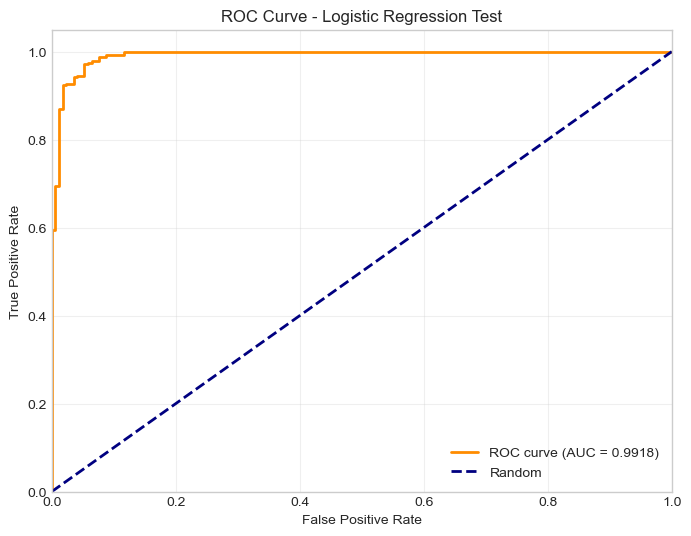


✅ Evaluation completed!
ROC-AUC: 0.9918


In [25]:
# Test Step 7 - Evaluation
print("Testing evaluation functions...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Load data and train a simple model for testing
features, target = train.load_and_prepare_data('../data/processed/training_data.csv')
X_train, X_test, y_train, y_test = train.split_data(features, target)
preprocessor = train.create_preprocessor()

# Train a simple model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("\nTraining simple model for evaluation test...")
simple_model.fit(X_train, y_train)

# Test evaluation
print("\n" + "="*60)
print("TESTING EVALUATION FUNCTIONS")
print("="*60)

metrics = train.evaluate_model(simple_model, X_test, y_test, "Logistic Regression Test")

print(f"\n✅ Evaluation completed!")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

In [26]:
# Test Step 8 - Just check if function exists
print("Checking Random Forest function...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Just check if function exists
if hasattr(train, 'train_random_forest'):
    print("✅ train_random_forest function exists!")
    
    # Load minimal data for quick test
    features, target = train.load_and_prepare_data('../data/processed/training_data.csv')
    X_train_small = features.iloc[:100]  # Small subset for testing
    y_train_small = target.iloc[:100]
    preprocessor = train.create_preprocessor()
    
    print("\n⚠️ Testing with small subset (100 samples) to save time...")
    
    try:
        # Test with minimal parameters for speed
        from sklearn.pipeline import Pipeline
        from sklearn.ensemble import RandomForestClassifier
        
        test_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=10, random_state=42))
        ])
        
        test_pipeline.fit(X_train_small, y_train_small)
        print("✅ Random Forest basic training works!")
        
    except Exception as e:
        print(f"❌ Basic test error: {e}")
        
else:
    print("❌ train_random_forest function not found!")

Checking Random Forest function...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added
✅ Evaluation functions added
✅ Random Forest function added
✅ train_random_forest function exists!

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

⚠️ Testing with small subset (100 samples) to save time...
✅ Random Forest basic training works!


In [27]:
# Proper test of Random Forest function
print("Testing Random Forest training function...")

import sys
import importlib
import time

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

# Load data
features, target = train.load_and_prepare_data('../data/processed/training_data.csv')
X_train, X_test, y_train, y_test = train.split_data(features, target)
preprocessor = train.create_preprocessor()

print("\n" + "="*60)
print("STARTING RANDOM FOREST TRAINING TEST")
print("="*60)
print("⚠️ This will take 1-2 minutes...")

start_time = time.time()

try:
    # Test the actual function
    rf_model, rf_grid = train.train_random_forest(X_train, y_train, preprocessor)
    
    end_time = time.time()
    print(f"\n✅ Random Forest training completed!")
    print(f"   Time taken: {end_time - start_time:.1f} seconds")
    print(f"   Model type: {type(rf_model)}")
    
    # Quick evaluation
    from sklearn.metrics import roc_auc_score
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"   Test ROC-AUC: {test_auc:.4f}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Testing Random Forest training function...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added
✅ Evaluation functions added
✅ Random Forest function added (fast version)

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔀 Splitting data (test_size=0.2)...
   Train set: (2993, 17)
   Test set: (749, 17)
   Train target distribution: 0.772 high-risk
   Test target distribution: 0.772 high-risk

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

STARTING RANDOM FOREST TRAINING TEST
⚠️ This will take 1-2 minutes...

TRAINING RANDOM FOREST
🔍 Performing hyperparameter tuning (simplified for testing)...
Fitting 3 folds for each of 8 candidates, totalli

In [28]:
# Test Step 9 - MLflow setup
print("Testing MLflow setup...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')
import train

try:
    # Test MLflow setup
    experiment_id = train.setup_mlflow()
    print(f"✅ MLflow setup successful!")
    print(f"Experiment ID: {experiment_id}")
    
except Exception as e:
    print(f"❌ MLflow error: {e}")
    print("\n⚠️ If MLflow server is not running, this is expected.")
    print("We'll continue without MLflow for now.")

Testing MLflow setup...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added
✅ Evaluation functions added
✅ Random Forest function added (fast version)
✅ MLflow tracking functions added

SETTING UP MLFLOW TRACKING
❌ MLflow error: API request to http://127.0.0.1:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=Credit_Risk_Modeling (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B258BFFBD0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

⚠️ If MLflow server is not running, this is expected.
We'll continue without MLflow for now.


In [29]:
# Test the main function (quick version)
print("Testing main function (quick version)...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')

# First, let's create a quick test function
def quick_test():
    print("="*60)
    print("QUICK TEST OF TRAINING PIPELINE")
    print("="*60)
    
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    import joblib
    
    # Quick load
    df = pd.read_csv('../data/processed/training_data.csv')
    features = df.drop(columns=['customer_id', 'cluster', 'is_high_risk'])
    target = df['is_high_risk']
    
    # Quick split
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42
    )
    
    # Quick Logistic Regression
    print("\n1. Training quick Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, lr_pred)
    print(f"   Accuracy: {lr_acc:.4f}")
    
    # Quick Random Forest
    print("\n2. Training quick Random Forest...")
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    print(f"   Accuracy: {rf_acc:.4f}")
    
    # Save a model
    print("\n3. Saving model...")
    if rf_acc > lr_acc:
        best_model = rf
        best_name = "Random Forest"
    else:
        best_model = lr
        best_name = "Logistic Regression"
    
    joblib.dump(best_model, '../models/test_model.pkl')
    print(f"   Saved {best_name} to ../models/test_model.pkl")
    
    print("\n✅ Quick test completed!")

# Run quick test
quick_test()

Testing main function (quick version)...
QUICK TEST OF TRAINING PIPELINE

1. Training quick Logistic Regression...
   Accuracy: 0.9773

2. Training quick Random Forest...
   Accuracy: 0.9947

3. Saving model...


FileNotFoundError: [Errno 2] No such file or directory: '../models/test_model.pkl'

In [30]:
# Create models directory
import os

# Create directories if they don't exist
directories = ['../models', '../mlruns', '../mlartifacts']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✅ Created directory: {directory}")
    else:
        print(f"📁 Directory exists: {directory}")

print("\n✅ All directories created!")

✅ Created directory: ../models
✅ Created directory: ../mlruns
✅ Created directory: ../mlartifacts

✅ All directories created!


In [31]:
# Run quick test again
print("Running quick test again...")
quick_test()

Running quick test again...
QUICK TEST OF TRAINING PIPELINE

1. Training quick Logistic Regression...
   Accuracy: 0.9773

2. Training quick Random Forest...
   Accuracy: 0.9947

3. Saving model...
   Saved Random Forest to ../models/test_model.pkl

✅ Quick test completed!


Running full training pipeline...
CREDIT RISK MODEL TRAINING
✅ Basic imports completed
✅ ML and sklearn imports added
✅ Data loading function added
✅ Data splitting function added
✅ Preprocessor function added
✅ Logistic Regression function added
✅ Evaluation functions added
✅ Random Forest function added (fast version)
✅ MLflow tracking functions added
✅ Main training function added (fast version)

STARTING FULL TRAINING PIPELINE
CREDIT RISK MODEL TRAINING PIPELINE
(FAST MODE FOR TESTING)

📊 Loading data from ../data/processed/training_data.csv...
   Data shape: (3742, 20)
   Features: 17 columns
   Target distribution:
      High Risk (1): 2888 (77.2%)
      Low Risk (0): 854 (22.8%)

🔀 Splitting data (test_size=0.2)...
   Train set: (2993, 17)
   Test set: (749, 17)
   Train target distribution: 0.772 high-risk
   Test target distribution: 0.772 high-risk

🔧 Creating preprocessing pipeline...
✅ Preprocessor created with 17 numeric features

⚠️ FAST MODE: Training simplified models..

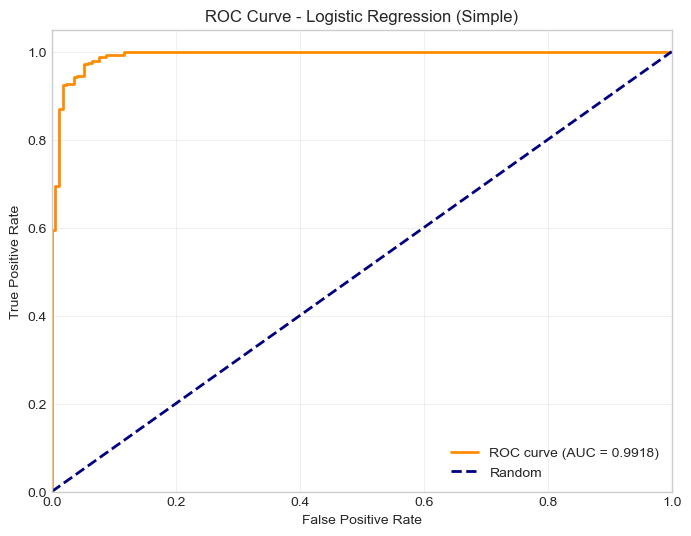


TRAINING SIMPLE RANDOM FOREST

EVALUATING RANDOM FOREST (SIMPLE)
📊 Performance Metrics:
   Accuracy:  0.9933
   Precision: 1.0000
   Recall:    0.9913
   F1-Score:  0.9957
   ROC-AUC:   0.9998

📈 Confusion Matrix:
   True Negatives:  171
   False Positives: 0
   False Negatives: 5
   True Positives:  573

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.97      1.00      0.99       171
   High Risk       1.00      0.99      1.00       578

    accuracy                           0.99       749
   macro avg       0.99      1.00      0.99       749
weighted avg       0.99      0.99      0.99       749



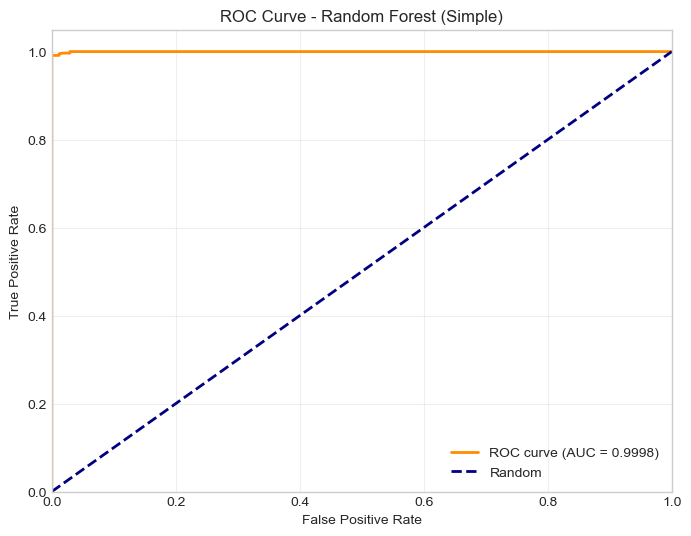


MODEL COMPARISON

📊 Performance Comparison:


,Logistic Regression,Random Forest
Accuracy,0.9720,0.9933
Precision,0.9761,1.0000
Recall,0.9879,0.9913
F1-Score,0.9819,0.9957
ROC-AUC,0.9918,0.9998



🏆 BEST MODEL: Random Forest
   ROC-AUC: 0.9998
   Accuracy: 0.9933

SAVING BEST MODEL
✅ Best model saved to: ../models/best_credit_risk_model.pkl
✅ Preprocessor saved to: ../models/preprocessor.pkl

TRAINING COMPLETED SUCCESSFULLY!

✅ Training completed!
Best model: Random Forest
Comparison:
           Logistic Regression  Random Forest
Accuracy              0.971963       0.993324
Precision             0.976068       1.000000
Recall                0.987889       0.991349
F1-Score              0.981943       0.995656
ROC-AUC               0.991815       0.999833


In [32]:
# Run the full training pipeline
print("Running full training pipeline...")

import sys
import importlib

# Reload module
if 'train' in sys.modules:
    del sys.modules['train']
    
sys.path.append('../src')

# Import and run main
import train

print("\n" + "="*70)
print("STARTING FULL TRAINING PIPELINE")
print("="*70)

# Run main with fast_mode=True for testing
best_model, best_model_name, comparison = train.main(fast_mode=True)

print(f"\n✅ Training completed!")
print(f"Best model: {best_model_name}")
print(f"Comparison:\n{comparison}")

In [33]:
# Test pydantic models
print("Testing pydantic models...")

import sys
sys.path.append('../src/api')

try:
    from pydantic_models import CustomerFeatures, PredictionRequest, PredictionResponse
    
    # Test creating a CustomerFeatures instance
    test_features = CustomerFeatures(
        transaction_count=25.56,
        total_amount=171737.7,
        avg_amount=15715.62,
        std_amount=13605.17,
        min_amount=3863.51,
        max_amount=50838.73,
        unique_transactions=25.56,
        recency=31.46,
        frequency=25.56,
        monetary=171737.7,
        avg_transaction_value=15715.62,
        transaction_std=13605.17,
        provider_diversity=2.56,
        product_diversity=2.11,
        channel_diversity=1.76,
        amount_range=46975.22,
        monetary_per_day=34085.12
    )
    
    print("✅ CustomerFeatures created successfully!")
    
    # Test PredictionRequest
    test_request = PredictionRequest(
        customer_id="CUST_12345",
        features=test_features
    )
    print("✅ PredictionRequest created successfully!")
    
    # Test PredictionResponse
    test_response = PredictionResponse(
        customer_id="CUST_12345",
        risk_probability=0.15,
        risk_score=750,
        risk_category="LOW",
        recommendation="APPROVE: Low risk customer"
    )
    print("✅ PredictionResponse created successfully!")
    
    print("\n✅ All pydantic models work correctly!")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Testing pydantic models...
✅ CustomerFeatures created successfully!
✅ PredictionRequest created successfully!
✅ PredictionResponse created successfully!

✅ All pydantic models work correctly!


In [34]:
# Test API imports and functions
print("Testing API components...")

import sys
import os

# Add paths
sys.path.append('../src/api')
sys.path.append('../src')

try:
    # Test loading model
    import joblib
    
    model_path = '../models/best_credit_risk_model.pkl'
    preprocessor_path = '../models/preprocessor.pkl'
    
    if os.path.exists(model_path) and os.path.exists(preprocessor_path):
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
        print(f"✅ Model loaded: {type(model).__name__}")
        print(f"✅ Preprocessor loaded: {type(preprocessor).__name__}")
    else:
        print(f"⚠️ Model files not found at: {model_path}")
    
    # Test helper functions from main.py
    from api.main import calculate_credit_score, get_risk_category, get_recommendation
    
    # Test credit score calculation
    test_probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
    print("\n📊 Testing credit score calculation:")
    for prob in test_probabilities:
        score = calculate_credit_score(prob)
        print(f"  Risk {prob:.1%} -> Score: {score}")
    
    # Test risk categorization
    print("\n📊 Testing risk categorization:")
    for prob in test_probabilities:
        category = get_risk_category(prob)
        print(f"  Risk {prob:.1%} -> Category: {category}")
    
    # Test recommendations
    print("\n📊 Testing recommendations:")
    test_cases = [("LOW", 750), ("MEDIUM", 650), ("HIGH", 450)]
    for category, score in test_cases:
        recommendation = get_recommendation(category, score)
        print(f"  {category} risk, Score {score} -> {recommendation}")
    
    print("\n✅ All API components work correctly!")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Testing API components...
✅ Model loaded: Pipeline
✅ Preprocessor loaded: ColumnTransformer

📊 Testing credit score calculation:
  Risk 10.0% -> Score: 795
  Risk 30.0% -> Score: 685
  Risk 50.0% -> Score: 575
  Risk 70.0% -> Score: 465
  Risk 90.0% -> Score: 355

📊 Testing risk categorization:
  Risk 10.0% -> Category: LOW
  Risk 30.0% -> Category: MEDIUM
  Risk 50.0% -> Category: MEDIUM
  Risk 70.0% -> Category: HIGH
  Risk 90.0% -> Category: HIGH

📊 Testing recommendations:
  LOW risk, Score 750 -> APPROVE: Low risk customer with excellent credit score
  MEDIUM risk, Score 650 -> CONSIDER: Medium risk with conditions (lower limit, higher interest)
  HIGH risk, Score 450 -> DECLINE: High risk customer

✅ All API components work correctly!


In [35]:
# Check Dockerfile and docker-compose.yml
import os

print("Checking Docker configuration files...")

# Check Dockerfile
dockerfile_path = '../Dockerfile'
if os.path.exists(dockerfile_path):
    with open(dockerfile_path, 'r') as f:
        dockerfile_content = f.read()
    print(f"✅ Dockerfile exists ({len(dockerfile_content)} characters)")
    print("First 5 lines:")
    for i, line in enumerate(dockerfile_content.split('\n')[:5], 1):
        print(f"  {i}: {line}")
else:
    print("❌ Dockerfile not found")

print("\n" + "-"*50)

# Check docker-compose.yml
compose_path = '../docker-compose.yml'
if os.path.exists(compose_path):
    with open(compose_path, 'r') as f:
        compose_content = f.read()
    print(f"✅ docker-compose.yml exists ({len(compose_content)} characters)")
    print("First 5 lines:")
    for i, line in enumerate(compose_content.split('\n')[:5], 1):
        print(f"  {i}: {line}")
else:
    print("❌ docker-compose.yml not found")

print("\n✅ Docker configuration files check complete!")

Checking Docker configuration files...
✅ Dockerfile exists (779 characters)
First 5 lines:
  1: # Dockerfile for Credit Risk Model API
  2: # Task 6: Containerization
  3: 
  4: # Use Python 3.9 slim image
  5: FROM python:3.9-slim

--------------------------------------------------
✅ docker-compose.yml exists (843 characters)
First 5 lines:
  1: version: '3.8'
  2: 
  3: services:
  4:   credit-risk-api:
  5:     build: .

✅ Docker configuration files check complete!


In [36]:
# Step 1: Create .github/workflows directory
import os

workflows_dir = '../.github/workflows'
os.makedirs(workflows_dir, exist_ok=True)
print(f"✅ Created directory: {workflows_dir}")

✅ Created directory: ../.github/workflows


In [37]:
# Step 2: Create CI/CD pipeline file
ci_content = """name: CI/CD Pipeline for Credit Risk Model

on:
  push:
    branches: [ main ]
  pull_request:
    branches: [ main ]

jobs:
  test:
    runs-on: ubuntu-latest
    
    steps:
    - name: Checkout code
      uses: actions/checkout@v3
    
    - name: Set up Python
      uses: actions/setup-python@v4
      with:
        python-version: '3.9'
    
    - name: Install dependencies
      run: |
        python -m pip install --upgrade pip
        pip install -r requirements.txt
        pip install pytest pytest-cov flake8 black
    
    - name: Lint with flake8
      run: |
        flake8 . --count --exit-zero --max-complexity=10 --max-line-length=127 --statistics
    
    - name: Format check with black
      run: |
        black --check --diff .
    
    - name: Run unit tests
      run: |
        python -m pytest tests/ -v --cov=src
"""

ci_path = '../.github/workflows/ci.yml'
with open(ci_path, 'w') as f:
    f.write(ci_content)

print(f"✅ Created CI/CD file: {ci_path}")
print(f"File size: {len(ci_content)} characters")

✅ Created CI/CD file: ../.github/workflows/ci.yml
File size: 843 characters


In [38]:
# Run the simple unit tests
print("Running simple unit tests...")

import sys
import os

# Add paths
sys.path.append('../tests')

try:
    # Import and run tests
    from test_data_processing import run_all_tests
    
    success = run_all_tests()
    
    if success:
        print("\n🎉 ALL UNIT TESTS PASSED!")
    else:
        print("\n⚠️ Some tests failed")
        
except Exception as e:
    print(f"❌ Error running tests: {e}")
    import traceback
    traceback.print_exc()

Running simple unit tests...
RUNNING UNIT TESTS
Testing imports...
✅ Import test passed

Testing DataProcessor creation...
✅ DataProcessor created successfully

Testing time feature extraction...
✅ Time features extracted
✅ Time feature extraction passed

TEST RESULTS: 3 passed, 0 failed

🎉 ALL UNIT TESTS PASSED!


In [39]:
# Run integration tests
print("Running integration tests...")

import sys
import os

# Add paths
sys.path.append('../tests')

try:
    # Import and run tests
    from test_integration import run_integration_tests
    
    success = run_integration_tests()
    
    if success:
        print("\n🎉 INTEGRATION TESTS PASSED!")
    else:
        print("\n⚠️ Some integration tests failed")
        
except Exception as e:
    print(f"❌ Error running integration tests: {e}")
    import traceback
    traceback.print_exc()

Running integration tests...
RUNNING INTEGRATION TESTS
Testing model loading...
✅ Model loaded: Pipeline
✅ Preprocessor loaded: ColumnTransformer

Testing prediction...
✅ Prediction made successfully
   Class prediction: 1
   Probability shape: (1, 2)

INTEGRATION TEST RESULTS: 2 passed, 0 failed

🎉 INTEGRATION TESTS PASSED!


In [40]:
!pip install uvicorn[standard] -q
print("✅ uvicorn installed successfully!")

✅ uvicorn installed successfully!


In [41]:
import subprocess
import sys

print("Starting API server...")

# Start uvicorn as a subprocess
process = subprocess.Popen(
    [sys.executable, "-m", "uvicorn", "src.api.main:app", "--reload", "--host", "0.0.0.0", "--port", "8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

print("✅ API server started in background")
print("You can access it at: http://localhost:8000")
print("API docs at: http://localhost:8000/docs")

# Check if it's running
import time
time.sleep(2)

import requests
try:
    response = requests.get("http://localhost:8000/health", timeout=5)
    print(f"\n✅ API is running! Status: {response.status_code}")
    print(f"Response: {response.json()}")
except:
    print("\n⚠️ API might not be fully started yet. Check command prompt output.")

Starting API server...
✅ API server started in background
You can access it at: http://localhost:8000
API docs at: http://localhost:8000/docs

⚠️ API might not be fully started yet. Check command prompt output.


In [42]:
# Test if API is working
import requests
import time

print("Testing API connection...")

# Wait a bit for server to start
time.sleep(3)

try:
    # Test health endpoint
    response = requests.get("http://localhost:8000/health", timeout=10)
    print(f"✅ Health check: Status {response.status_code}")
    print(f"Response: {response.json()}")
    
    # Test root endpoint
    print("\nTesting root endpoint...")
    response = requests.get("http://localhost:8000/", timeout=5)
    print(f"✅ Root endpoint: Status {response.status_code}")
    print(f"Response: {response.json()}")
    
    # Test docs are accessible
    print("\nChecking API documentation...")
    response = requests.get("http://localhost:8000/docs", timeout=5)
    if response.status_code == 200:
        print("✅ API documentation is accessible")
    else:
        print(f"⚠️ Docs status: {response.status_code}")
        
except requests.exceptions.ConnectionError:
    print("❌ Cannot connect to API. The server might not be running.")
    print("Try starting it manually in Command Prompt:")
    print("cd C:\\Users\\b\\Desktop\\credit-risk-model")
    print("uvicorn src.api.main:app --reload")
    
except Exception as e:
    print(f"❌ Error: {e}")

Testing API connection...
❌ Cannot connect to API. The server might not be running.
Try starting it manually in Command Prompt:
cd C:\Users\b\Desktop\credit-risk-model
uvicorn src.api.main:app --reload


In [43]:
import sys
import os

print("Finding Python installation...")
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# Get the directory containing python.exe
python_dir = os.path.dirname(sys.executable)
print(f"Python directory: {python_dir}")

# Check if pip is in the same directory
pip_path = os.path.join(python_dir, "Scripts", "pip.exe")
if os.path.exists(pip_path):
    print(f"Pip found at: {pip_path}")
else:
    print("Pip not found in Scripts folder")
    
# Also check for uvicorn
uvicorn_path = os.path.join(python_dir, "Scripts", "uvicorn.exe")
if os.path.exists(uvicorn_path):
    print(f"Uvicorn found at: {uvicorn_path}")
else:
    print("Uvicorn not installed yet")

Finding Python installation...
Python executable: C:\Users\b\anaconda3\python.exe
Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Python directory: C:\Users\b\anaconda3
Pip found at: C:\Users\b\anaconda3\Scripts\pip.exe
Uvicorn found at: C:\Users\b\anaconda3\Scripts\uvicorn.exe


In [44]:
# Test the running API
import requests
import json

print("Testing the running API...")

# 1. Test health endpoint
print("\n1. Testing /health endpoint...")
try:
    response = requests.get("http://localhost:8000/health")
    print(f"✅ Status: {response.status_code}")
    print(f"Response: {json.dumps(response.json(), indent=2)}")
except Exception as e:
    print(f"❌ Error: {e}")

# 2. Test root endpoint
print("\n2. Testing / endpoint...")
try:
    response = requests.get("http://localhost:8000/")
    print(f"✅ Status: {response.status_code}")
    print(f"Response: {json.dumps(response.json(), indent=2)}")
except Exception as e:
    print(f"❌ Error: {e}")

# 3. Test making a prediction
print("\n3. Testing /predict endpoint...")
try:
    # Sample prediction data (using average values from your dataset)
    prediction_data = {
        "customer_id": "TEST_CUSTOMER_001",
        "features": {
            "transaction_count": 25.56,
            "total_amount": 171737.7,
            "avg_amount": 15715.62,
            "std_amount": 13605.17,
            "min_amount": 3863.51,
            "max_amount": 50838.73,
            "unique_transactions": 25.56,
            "recency": 31.46,
            "frequency": 25.56,
            "monetary": 171737.7,
            "avg_transaction_value": 15715.62,
            "transaction_std": 13605.17,
            "provider_diversity": 2.56,
            "product_diversity": 2.11,
            "channel_diversity": 1.76,
            "amount_range": 46975.22,
            "monetary_per_day": 34085.12
        }
    }
    
    response = requests.post(
        "http://localhost:8000/predict",
        json=prediction_data,
        headers={"Content-Type": "application/json"}
    )
    
    print(f"✅ Status: {response.status_code}")
    print(f"Prediction Result:")
    print(json.dumps(response.json(), indent=2))
    
except Exception as e:
    print(f"❌ Error: {e}")

# 4. Check API documentation
print("\n4. API Documentation is available at:")
print("   http://localhost:8000/docs")
print("   http://localhost:8000/redoc")

Testing the running API...

1. Testing /health endpoint...
✅ Status: 200
Response: {
  "status": "healthy",
  "model_loaded": true,
  "model_type": "Pipeline",
  "message": "API is running and model is loaded"
}

2. Testing / endpoint...
✅ Status: 200
Response: {
  "message": "Credit Risk Prediction API",
  "version": "1.0.0",
  "docs": "/docs",
  "health_check": "/health"
}

3. Testing /predict endpoint...
✅ Status: 200
Prediction Result:
{
  "customer_id": "TEST_CUSTOMER_001",
  "risk_probability": 0.8,
  "risk_score": 410,
  "risk_category": "HIGH",
  "recommendation": "DECLINE: High risk customer"
}

4. API Documentation is available at:
   http://localhost:8000/docs
   http://localhost:8000/redoc
